In [1]:
from sklearn.datasets import make_gaussian_quantiles
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
from sklearn.datasets import make_gaussian_quantiles,make_moons,make_classification,make_circles
# Construct dataset
# X1, y1 = make_gaussian_quantiles(cov=3.,
#                                  n_samples=10000, n_features=2,
#                                  n_classes=2, random_state=1)
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1,n_samples=1000)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0,n_samples=1000),
            make_circles(noise=0.2, factor=0.5, random_state=1,n_samples=1000),
            linearly_separable
            ]

In [3]:
X, y = datasets[2]

In [4]:
x_train, x_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

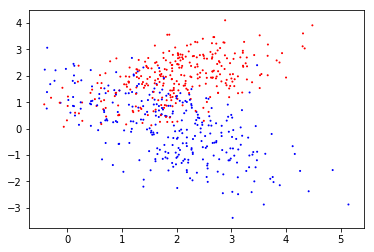

In [5]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train,
            s=1, cmap=cm_bright);

In [6]:
var = np.var(x_train,axis = 0)
mean = np.mean(x_train,axis = 0)

In [7]:
C = 32 # partition sum
classes = 2

M = np.random.multivariate_normal(mean,[[var[0],0],[0,var[1]]],(C))

x_train.max()

# M[:,1] = (M[:,1] -0.5) * 4 + 2

PI = np.random.rand(C,classes)
k = 10
# PI = np.ones((C,classes))*0.5

In [8]:
def dist_softmax_forward(M,x, beta = 10):#M shape (C,2) x (2)
    x_as_M = np.tile(np.expand_dims(x,axis = 0),(C,1))
    ex = np.exp(-beta * np.sum((M - x_as_M)**2,axis = 1)/2)
    W = ex/np.sum(ex)
    return W

In [9]:
def find_knn(X,k = 10):
    tree = KDTree(x_train, leaf_size=2)
    dist, ind = tree.query(x_train, k=k)
    return dist, ind

In [10]:
dist, ind = find_knn(x_train)

In [11]:
Px = np.zeros((len(x_train),classes))

for m in range(len(x_train)):
    for n in range(k):
        Px[m][y_train[ind[m]][n]] += 1.

Px = Px/k    

In [12]:
W_set = []
for i in range(len(x_train)):
    W_set.append (dist_softmax_forward(M,x_train[i]))

In [13]:
def empirical_info_loss(M,PI,X,Y,k = 10):
    
    L = 0   
    
    for i in range(len(X)):
        
        
        for k in range(C):
            
            m = Px[i]/PI[k]
            
            

            
            Div = np.sum(Px[i] * np.where(m != 0, np.log2(m), 0))
            L += W_set[i][k] * Div
            
    return L

In [14]:
def update_m(M,PI,X,Y,alpha = 0.01,beta = 10,k = 10):
    
    D = np.zeros(M.shape)
    
    for i in range(len(X)):

        for j in range(C):
            PxPI = Px[i]/PI[j]

            Div = np.sum(Px[i] * np.where(PxPI != 0, np.log2(PxPI), 0))
            
            
            x_as_M = np.tile(np.expand_dims(X[i],axis = 0),(C,1))
            
            
            dwj_dmk = beta * np.tile(np.expand_dims(- W_set[i] * W_set[i][j],axis = 1),(1,2)) * (x_as_M - M)
            
            
            dwj_dmk[j] += beta * W_set[i][j]* (x_as_M - M)[j]
            
            
            
            D = D + Div * dwj_dmk
    M[:] = M - alpha * D

In [15]:
def update_pi(M,PI,X,Y,k = 10):

    U = np.zeros((C,classes))
    
    for k in range(C):
        for i in range(len(X)):
            U[k] = U[k] + W_set[i][k] * Px[i]
#             print(W[k]*Px[i])
            
    L = np.tile(np.expand_dims(np.sum(U,axis = 1),axis = 1),(1,classes))
    PI[:] = (U/L)[:]

In [16]:
W_set = []
loss = []
for i in range(len(x_train)):
    W_set.append (dist_softmax_forward(M,x_train[i]))
    
for i in range(0,100):
    
    update_pi(M,PI,x_train,y_train)
    update_m(M,PI,x_train,y_train)
    L = empirical_info_loss(M,PI,x_train,y_train)
    
    print(i,L)
    loss.append(L)
    W_set = []
    for i in range(len(x_train)):
        W_set.append (dist_softmax_forward(M,x_train[i]))

/home/leeyh/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.
/home/leeyh/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


0 54.450079429523534
1 52.1038453753654
2 49.97263092822772
3 48.44009783641379
4 47.27077769132966
5 46.32251128071526
6 45.53990129032479
7 44.88615007685071
8 44.33446207266498
9 43.86497686760983
10 43.46253521062253
11 43.11517599313998
12 42.81324204642127
13 42.548858237802726
14 42.31559040268097
15 42.10818322953529
16 41.92234230308493
17 41.75455478081589
18 41.60194717244182
19 41.46217448823866
20 41.333332334863044
21 41.213884275982906
22 41.10259926409593
23 40.99849637810815
24 40.90079569739012
25 40.8088749392312
26 40.722231787625695
27 40.640451905930576
28 40.563182586711584
29 40.490111892852255
30 40.42095299726373
31 40.35543325227764
32 40.293287346217156
33 40.23425377161562
34 40.178073766443624
35 40.124491907723026
36 40.07325762754347
37 40.02412706205476
38 39.97686480613946
39 39.93124530445293
40 39.88705374499555
41 39.844086425033744
42 39.8021506295105
43 39.76106410303717
44 39.72065421465647
45 39.68075691718659
46 39.64121559639226
47 39.60187989

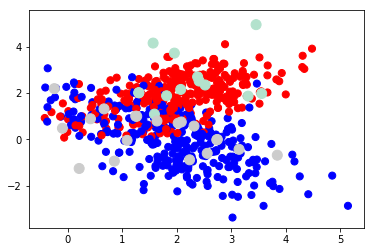

In [17]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train,
            s=50, cmap=cm_bright);
plt.scatter(M[:, 0], M[:, 1], c=np.argmax(PI,axis = 1),
            s=100, cmap='Pastel2');

In [18]:
h = .02 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

In [19]:
def predict_proba(M,PI,X):
    tree = KDTree(M, leaf_size=2)
    dist, ind = tree.query(X, k=1)
    return dist,ind

In [20]:
dist,ind = predict_proba(M,PI,x_test)

In [21]:
Z = PI[ind][:,0,:]

In [22]:
s = (np.argmax(Z,axis = 1) == y_test)
score = s.sum()/len(s)

In [23]:
dist,ind = predict_proba(M,PI,np.c_[xx.ravel(), yy.ravel()])

In [24]:
Z = PI[ind][:,0,1]

In [25]:
Z = Z.reshape(xx.shape)

In [26]:
x_train.shape

(600, 2)

Text(5.330672605240474, -3.5971824908134398, '.85')

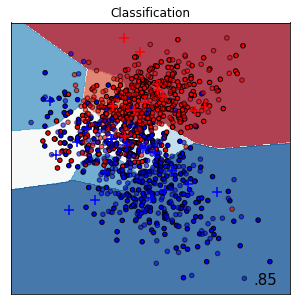

In [27]:
figure = plt.figure(figsize=(5, 5))
cm = plt.cm.RdBu
ax = plt.subplot()
ax.set_title("Classification")
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright,s=20,
               edgecolors='k')
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,s=20,
               edgecolors='k')
ax.scatter(M[:, 0], M[:, 1], c=np.argmax(PI,axis = 1),
            s=100, cmap=cm_bright,marker='+',
               edgecolors='k');
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

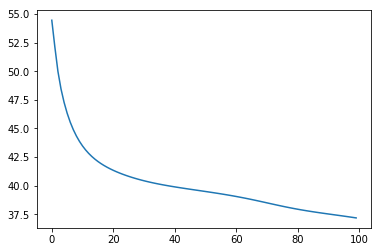

In [31]:
plt.plot(loss)